In [1]:
"""
AirREGI ヘルプデスク入電予測 - 特徴量エンジニアリング完全版

このスクリプトでは、時系列データに対する適切な特徴量作成方法を示します。
特にデータリーケージ（Data Leakage）の防止に注意を払っています。

重要な原則:
1. 未来のデータを使わない（ラグ特徴量は過去のデータのみ）
2. 移動平均も過去のデータのみを使用
3. 訓練データとテストデータは時系列で分割
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==================================================================================
# Step 1: データの読み込みと前処理
# ==================================================================================

def load_and_preprocess_data():
    """
    各データセットを読み込み、日付型に変換
    """
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    # データ読み込み
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    # 日付カラムをdatetime型に変換
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nカレンダーデータ: {calender.shape}")
    print(f"CMデータ: {cm_data.shape}")
    print(f"Google Trendsデータ: {gt_service.shape}")
    print(f"アカウント取得データ: {acc_get.shape}")
    print(f"入電データ（目的変数）: {call_data.shape}")
    
    return calender, cm_data, gt_service, acc_get, call_data


# ==================================================================================
# Step 2: データの統合
# ==================================================================================

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    """
    全てのデータセットを統合
    Google Trendsは週次データなので日次に展開
    """
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    # メインデータ（入電数）を基準にマージ
    df = call_data.copy()
    print(f"\nベースデータ: {df.shape}")
    
    # カレンダー情報をマージ
    df = df.merge(calender, on='cdr_date', how='left')
    print(f"カレンダー情報マージ後: {df.shape}")
    
    # CM情報をマージ
    df = df.merge(cm_data, on='cdr_date', how='left')
    print(f"CM情報マージ後: {df.shape}")
    
    # アカウント取得数をマージ
    df = df.merge(acc_get, on='cdr_date', how='left')
    print(f"アカウント取得数マージ後: {df.shape}")
    
    # Google Trendsデータは週次なので日次に展開
    print("\nGoogle Trendsデータを週次→日次に展開...")
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({
                'cdr_date': date, 
                'search_cnt': row['search_cnt']
            })
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    print(f"Google Trendsマージ後: {df.shape}")
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    
    return df


In [3]:
# ==================================================================================
# Step 3: 基本的な時系列特徴量の作成
# ==================================================================================

def create_basic_time_features(df):
    """
    日付から派生する基本的な時系列特徴量を作成
    これらは未来の情報を使わないので安全
    """
    print("\n" + "=" * 80)
    print("Step 3: 基本的な時系列特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 年月日の特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    
    # 週の情報（既にwoy, womがあるが念のため）
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    
    # 経過日数（データの開始日からの日数）
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    
    # 曜日情報（既にdowがあるが確認）
    # dow: 1=月, 2=火, ..., 7=日
    
    # 月初・月末フラグ
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    print("\n作成した基本特徴量:")
    time_features = ['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 
                     'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']
    print(time_features)
    
    return df

In [4]:
# ==================================================================================
# Step 4: ラグ特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    """
    ラグ特徴量（過去のデータ）を作成
    
    重要: 
    - shift()を使って、未来の情報が混入しないようにする
    - lag=1は1日前のデータ、lag=7は7日前のデータ
    
    例: 
    日付        call_num    lag_1    lag_7
    2018-06-01    183        NaN      NaN
    2018-06-02      0        183      NaN
    2018-06-08     96         0       183  <- 7日前のデータ
    """
    print("\n" + "=" * 80)
    print("Step 4: ラグ特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"作成するラグ: {lags}")
    
    for lag in lags:
        col_name = f'lag_{lag}'
        df[col_name] = df[target_col].shift(lag)
        print(f"  作成: {col_name} (shift={lag})")
    
    # 最初のN日はラグ特徴量がNaNになる
    print(f"\n注意: 最初の{max(lags)}日間はラグ特徴量がNaNになります")
    print(f"例: lag_30は最初の30日間がNaN")
    
    return df


In [5]:
# ==================================================================================
# Step 5: 移動平均特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    """
    移動平均・移動標準偏差を作成
    
    重要:
    - rolling().mean() を使う前に shift(1) を適用
    - これにより、当日のデータが移動平均に含まれない（リーケージ防止）
    
    例（window=3の場合）:
    日付        call_num    過去3日の平均
    2018-06-01    183        NaN
    2018-06-02      0        NaN
    2018-06-03      0        NaN
    2018-06-04    213        61.0  <- (183+0+0)/3 = 61.0
    """
    print("\n" + "=" * 80)
    print("Step 5: 移動平均特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"移動平均ウィンドウ: {windows}")
    
    for window in windows:
        # 移動平均（当日を含まない＝shift(1)してからrolling）
        ma_col = f'ma_{window}'
        df[ma_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        print(f"  作成: {ma_col} (過去{window}日間の平均)")
        
        # 移動標準偏差（変動の大きさを捉える）
        std_col = f'ma_std_{window}'
        df[std_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        print(f"  作成: {std_col} (過去{window}日間の標準偏差)")
    
    print("\nなぜshift(1)が必要か:")
    print("  × 悪い例: rolling(3).mean() → 当日含む3日間の平均（リーケージ！）")
    print("  ○ 良い例: shift(1).rolling(3).mean() → 過去3日間の平均（安全）")
    
    return df



In [6]:
# ==================================================================================
# Step 6: その他の集約特徴量
# ==================================================================================

def create_aggregated_features(df):
    """
    その他の有用な集約特徴量を作成
    """
    print("\n" + "=" * 80)
    print("Step 6: その他の集約特徴量")
    print("=" * 80)
    
    df = df.copy()
    
    # CM効果の累積（過去7日間のCM実施回数）
    # これも当日を含まないようにshift(1)
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    print("  作成: cm_7d (過去7日間のCM実施回数)")
    
    # Google Trendsの移動平均（ノイズ除去）
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: gt_ma_7 (過去7日間のGoogle Trends平均)")
    
    # アカウント取得数の移動平均
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: acc_ma_7 (過去7日間のアカウント取得平均)")
    
    # 曜日ごとの過去平均（同じ曜日の過去データの平均）
    # これは少し高度だが、曜日パターンを捉えるのに有効
    print("\n  作成中: dow_avg (同じ曜日の過去平均)...")
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        # 各行について、その行より前のデータの平均を計算
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [7]:
# ==================================================================================
# Step 7: 特徴量の選択とデータ分割
# ==================================================================================

def select_features_and_split(df, test_months=3):
    """
    特徴量を選択し、訓練データとテストデータに分割
    
    重要: 時系列データは時間順に分割する
    """
    print("\n" + "=" * 80)
    print("Step 7: 特徴量選択とデータ分割")
    print("=" * 80)
    
    # 平日のみを使用（土日は入電数が0なので予測不要）
    df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)
    print(f"\n平日のみに絞り込み: {len(df)} → {len(df_model)}行")
    
    # 特徴量リスト
    feature_cols = [
        # 基本的な時系列特徴量
        'dow', 'day_of_month', 'month', 'quarter', 'year', 
        'days_from_start', 'day_of_year', 'week_of_year',
        'is_month_start', 'is_month_end',
        
        # カレンダー特徴量
        'woy', 'wom', 'day_before_holiday_flag',
        
        # 外部データ
        'cm_flg', 'acc_get_cnt', 'search_cnt',
        
        # 集約特徴量
        'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
        
        # ラグ特徴量
        'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
        
        # 移動平均特徴量
        'ma_3', 'ma_7', 'ma_14', 'ma_30',
        'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
    ]
    
    print(f"\n使用する特徴量数: {len(feature_cols)}")
    print("\n特徴量のカテゴリ:")
    print(f"  - 基本時系列: 10個")
    print(f"  - カレンダー: 3個")
    print(f"  - 外部データ: 3個")
    print(f"  - 集約特徴量: 4個")
    print(f"  - ラグ特徴量: 7個")
    print(f"  - 移動平均: 8個")
    
    # 時系列分割（最後の3ヶ月をテストデータ）
    split_date = df_model['cdr_date'].max() - pd.Timedelta(days=30*test_months)
    
    train_df = df_model[df_model['cdr_date'] < split_date].copy()
    test_df = df_model[df_model['cdr_date'] >= split_date].copy()
    
    print(f"\n時系列分割:")
    print(f"  訓練データ期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
    print(f"  テストデータ期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
    print(f"  訓練データ数: {len(train_df)}行")
    print(f"  テストデータ数: {len(test_df)}行")
    
    # 欠損値がある行を削除（ラグ特徴量の初期値等）
    train_clean = train_df.dropna(subset=feature_cols + ['call_num'])
    test_clean = test_df.dropna(subset=feature_cols + ['call_num'])
    
    print(f"\n欠損値除去後:")
    print(f"  訓練データ数: {len(train_clean)}行")
    print(f"  テストデータ数: {len(test_clean)}行")
    
    # X（特徴量）とy（目的変数）に分割
    X_train = train_clean[feature_cols]
    y_train = train_clean['call_num']
    X_test = test_clean[feature_cols]
    y_test = test_clean['call_num']
    
    # メタ情報も保存（日付など）
    train_meta = train_clean[['cdr_date', 'call_num']]
    test_meta = test_clean[['cdr_date', 'call_num']]
    
    return X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols

In [8]:
# ==================================================================================
# Step 8: 特徴量の重要度確認用関数
# ==================================================================================

def analyze_features(X_train, y_train, feature_cols):
    """
    特徴量の基本統計と相関を確認
    """
    print("\n" + "=" * 80)
    print("Step 8: 特徴量の分析")
    print("=" * 80)
    
    # 基本統計量
    print("\n特徴量の基本統計:")
    print(X_train.describe().T[['mean', 'std', 'min', 'max']].head(10))
    
    # 目的変数との相関
    print("\n目的変数との相関（上位10）:")
    correlations = pd.DataFrame({
        'feature': feature_cols,
        'correlation': [X_train[col].corr(y_train) for col in feature_cols]
    }).sort_values('correlation', ascending=False, key=abs)
    
    print(correlations.head(10))
    
    return correlations

In [12]:
# ==================================================================================
# メイン実行関数
# ==================================================================================

def main():
    """
    全ての処理を実行
    """
    print("\n")
    print("*" * 80)
    print("AirREGI ヘルプデスク入電予測 - 特徴量エンジニアリング")
    print("*" * 80)
    
    # Step 1: データ読み込み
    calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
    
    # Step 2: データ統合
    df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
    
    # Step 3: 基本時系列特徴量
    df = create_basic_time_features(df)
    
    # Step 4: ラグ特徴量
    df = create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30])
    
    # Step 5: 移動平均特徴量
    df = create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30])
    
    # Step 6: その他集約特徴量
    df = create_aggregated_features(df)
    
    # Step 7: 特徴量選択とデータ分割
    X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols = \
        select_features_and_split(df, test_months=3)
    
    # Step 8: 特徴量分析
    correlations = analyze_features(X_train, y_train, feature_cols)
    
    # データ保存
    print("\n" + "=" * 80)
    print("データの保存")
    print("=" * 80)
    
    # output ディレクトリが存在しない場合は作成
    import os
    output_dir = '../output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"  {output_dir} ディレクトリを作成しました")
    
    train_data = pd.concat([train_meta.reset_index(drop=True), 
                           X_train.reset_index(drop=True)], axis=1)
    test_data = pd.concat([test_meta.reset_index(drop=True), 
                          X_test.reset_index(drop=True)], axis=1)
    
    train_data.to_csv('../output/train_features.csv', index=False)
    test_data.to_csv('../output/test_features.csv', index=False)
    correlations.to_csv('../output/feature_correlations.csv', index=False)
    
    print("\n保存完了:")
    print("  - train_features.csv")
    print("  - test_features.csv")
    print("  - feature_correlations.csv")
    
    print("\n" + "=" * 80)
    print("特徴量エンジニアリング完了！")
    print("=" * 80)
    print(f"\n訓練データ: {X_train.shape}")
    print(f"テストデータ: {X_test.shape}")
    print(f"特徴量数: {len(feature_cols)}")
    
    return df, X_train, X_test, y_train, y_test, feature_cols

In [13]:
# ==================================================================================
# 実行
# ==================================================================================

if __name__ == "__main__":
    df, X_train, X_test, y_train, y_test, feature_cols = main()



********************************************************************************
AirREGI ヘルプデスク入電予測 - 特徴量エンジニアリング
********************************************************************************
Step 1: データの読み込み

カレンダーデータ: (670, 10)
CMデータ: (762, 2)
Google Trendsデータ: (109, 2)
アカウント取得データ: (701, 2)
入電データ（目的変数）: (670, 2)

Step 2: データの統合

ベースデータ: (670, 2)
カレンダー情報マージ後: (670, 11)
CM情報マージ後: (670, 12)
アカウント取得数マージ後: (670, 13)

Google Trendsデータを週次→日次に展開...
Google Trendsマージ後: (670, 14)

欠損値の数:
holiday_name               632
cdr_date                     0
call_num                     0
dow                          0
dow_name                     0
woy                          0
wom                          0
doy                          0
financial_year               0
day_before_holiday_flag      0
dtype: int64

Step 3: 基本的な時系列特徴量の作成

作成した基本特徴量:
['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']

Step 4: ラグ特徴量の作成（データリーケ

In [17]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)

# =========================
# 0) Load
# =========================
TRAIN_PATH = "../output/train_features.csv"

TEST_PATH  = "../output/test_features.csv"

train = pd.read_csv(TRAIN_PATH, parse_dates=["cdr_date"])
test  = pd.read_csv(TEST_PATH,  parse_dates=["cdr_date"])

TARGET = "call_num"
DROP_COLS = ["cdr_date", TARGET]

X_train = train.drop(columns=DROP_COLS)
y_train = train[TARGET].astype(float)

X_test  = test.drop(columns=DROP_COLS)
y_test  = test[TARGET].astype(float)

feature_cols = X_train.columns.tolist()

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Example features:", feature_cols[:10])

# =========================
# 1) Metrics helper
# =========================
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

results = []

def add_result(name, y_pred):
    m = evaluate(y_test, y_pred)
    results.append({"Model": name, **m})

# =========================
# 2) Baselines（超重要）
# =========================
# (A) 前日踏襲: yhat = lag_1
if "lag_1" in X_test.columns:
    add_result("Baseline: lag_1 (y[t-1])", X_test["lag_1"].values)
else:
    print("[skip] lag_1 not found")

# (B) 先週同曜日踏襲: yhat = lag_7
if "lag_7" in X_test.columns:
    add_result("Baseline: lag_7 (y[t-7])", X_test["lag_7"].values)
else:
    print("[skip] lag_7 not found")

# (C) 過去7日平均: yhat = ma_7
if "ma_7" in X_test.columns:
    add_result("Baseline: ma_7", X_test["ma_7"].values)
else:
    print("[skip] ma_7 not found")

# (D) 混合（地味に強いことが多い）
# 例: 直近と週次をブレンド
if ("lag_1" in X_test.columns) and ("lag_7" in X_test.columns):
    yhat = 0.7 * X_test["lag_1"].values + 0.3 * X_test["lag_7"].values
    add_result("Baseline: 0.7*lag_1 + 0.3*lag_7", yhat)

# =========================
# 3) Models（まずはsklearnで堅く）
# =========================
models = {}

# Ridge（説明しやすく、外れに強め。まず置く）
models["Ridge"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

# ランダムフォレスト（非線形・相互作用）
models["RandomForest"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# ExtraTrees（RFより強いことも多い）
models["ExtraTrees"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", ExtraTreesRegressor(
        n_estimators=800,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# 勾配ブースティング（古典）
models["GradientBoosting"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(random_state=42))
])

# HistGradientBoosting（高速で強いこと多い）
models["HistGradientBoosting"] = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        max_depth=None,
        learning_rate=0.05,
        max_iter=2000,
        random_state=42
    ))
])

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    add_result(name, pred)

# =========================
# 4) Optional: XGBoost / LightGBM / CatBoost（入ってたら試す）
# =========================
# 時系列なので「trainの最後の一部」をvalidにしてearly stoppingする
# （本当はrolling CVが理想だけど、まずはこれでOK）
def time_valid_split(df_train, valid_days=60):
    df = df_train.sort_values("cdr_date").copy()
    cutoff = df["cdr_date"].max() - pd.Timedelta(days=valid_days)
    tr = df[df["cdr_date"] < cutoff]
    va = df[df["cdr_date"] >= cutoff]
    return tr, va

tr_df, va_df = time_valid_split(train, valid_days=60)

X_tr = tr_df.drop(columns=DROP_COLS)
y_tr = tr_df[TARGET].astype(float)
X_va = va_df.drop(columns=DROP_COLS)
y_va = va_df[TARGET].astype(float)

# XGBoost
try:
    from xgboost import XGBRegressor

    xgb = XGBRegressor(
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        verbose=False
    )
    pred = xgb.predict(X_test)
    add_result("XGBoost", pred)
except Exception as e:
    print("[skip] XGBoost:", e)

# LightGBM
try:
    import lightgbm as lgb

    lgbm = lgb.LGBMRegressor(
        n_estimators=20000,
        learning_rate=0.02,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    pred = lgbm.predict(X_test)
    add_result("LightGBM", pred)
except Exception as e:
    print("[skip] LightGBM:", e)

# CatBoost
try:
    from catboost import CatBoostRegressor

    cat = CatBoostRegressor(
        iterations=20000,
        learning_rate=0.03,
        depth=8,
        loss_function="MAE",
        random_seed=42,
        verbose=False
    )
    cat.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True)
    pred = cat.predict(X_test)
    add_result("CatBoost", pred)
except Exception as e:
    print("[skip] CatBoost:", e)

# =========================
# 5) Show results
# =========================
res_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)
print("\n=== Results (sorted by MAE) ===")
print(res_df)

# 保存したいなら
res_df.to_csv("../output/model_results.csv", index=False)
print("\nSaved: ../output/model_results.csv")

Train: (392, 35) Test: (65, 35)
Example features: ['dow', 'day_of_month', 'month', 'quarter', 'year', 'days_from_start', 'day_of_year', 'week_of_year', 'is_month_start', 'is_month_end']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 349, number of used features: 35
[LightGBM] [Info] Start training from score 166.386819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Model: CatBoostRegressor
Test MAE : 32.473
Test RMSE: 43.772
Test R2  : 0.175


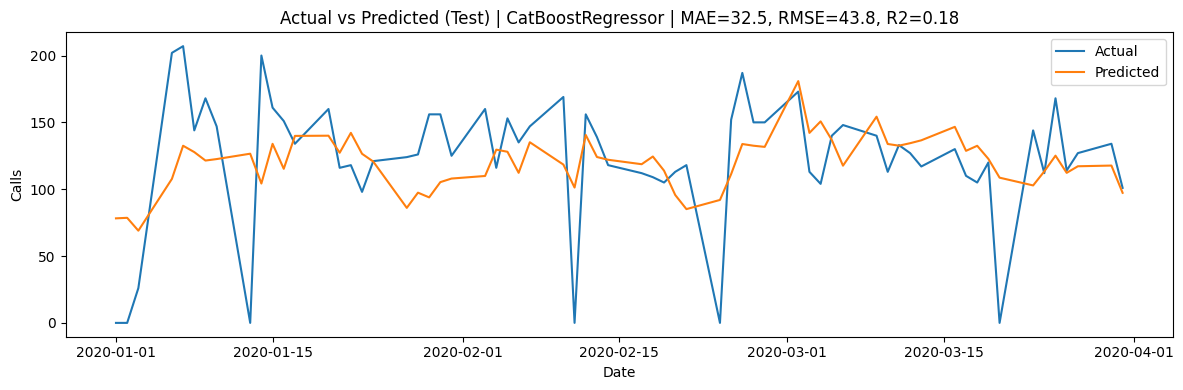

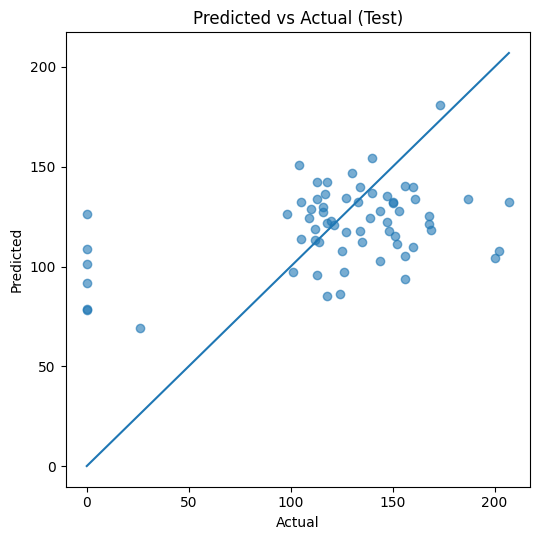

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

TRAIN_PATH = "../output/train_features.csv"  # ←あなたの環境に合わせて
TEST_PATH  = "../output/test_features.csv"   # ←

train = pd.read_csv(TRAIN_PATH, parse_dates=["cdr_date"])
test  = pd.read_csv(TEST_PATH,  parse_dates=["cdr_date"])

TARGET = "call_num"
X_train = train.drop(columns=["cdr_date", TARGET])
y_train = train[TARGET].astype(float)

X_test  = test.drop(columns=["cdr_date", TARGET])
y_test  = test[TARGET].astype(float)

# ===== モデル（CatBoostが使えればCatBoost、無ければRidgeにフォールバック）=====
y_pred = None
model_name = None

try:
    from catboost import CatBoostRegressor
    model = CatBoostRegressor(
        iterations=5000,
        learning_rate=0.03,
        depth=8,
        loss_function="MAE",
        random_seed=42,
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = "CatBoostRegressor"
except Exception as e:
    print("CatBoost not available, fallback to Ridge:", e)
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Ridge

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0, random_state=42))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = "Ridge (fallback)"

# ===== 指標 =====
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"Model: {model_name}")
print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2  : {r2:.3f}")

plot_df = pd.DataFrame({
    "date": test["cdr_date"],
    "actual": y_test.values,
    "pred": np.asarray(y_pred, dtype=float)
}).sort_values("date")

# ===== 図1：時系列で重ねる（いつ外してるかが一目）=====
plt.figure(figsize=(12, 4))
plt.plot(plot_df["date"], plot_df["actual"], label="Actual")
plt.plot(plot_df["date"], plot_df["pred"], label="Predicted")
plt.title(f"Actual vs Predicted (Test) | {model_name} | MAE={mae:.1f}, RMSE={rmse:.1f}, R2={r2:.2f}")
plt.xlabel("Date")
plt.ylabel("Calls")
plt.legend()
plt.tight_layout()
plt.show()
weekly = plot_df.set_index("date")[["actual","pred"]].resample("W").mean()

# ===== 図2：散布図（当たるほど45度線に近い）=====
plt.figure(figsize=(5.5, 5.5))
plt.scatter(plot_df["actual"], plot_df["pred"], alpha=0.6)
mn = min(plot_df["actual"].min(), plot_df["pred"].min())
mx = max(plot_df["actual"].max(), plot_df["pred"].max())
plt.plot([mn, mx], [mn, mx])  # y=x
plt.title("Predicted vs Actual (Test)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

z = df["acc_get_cnt"].astype(float)

sigma = 80.7462875362516
mu    = 121.82310984308629

x_hat = z * sigma + mu
x_int = np.rint(x_hat)  # 四捨五入して整数化（浮動小数の誤差対策）

# 再標準化して元のzに戻るか
z_back = (x_int - mu) / sigma

print("max abs diff:", np.max(np.abs(z - z_back)))
print("non-integer residual (before round):", np.max(np.abs(x_hat - np.rint(x_hat))))
print("min reconstructed:", x_int.min(), "max reconstructed:", x_int.max())


max abs diff: 3.5438318946034997e-13
non-integer residual (before round): 2.8535396268125623e-11
min reconstructed: 0.0 max reconstructed: 699.0


In [22]:
median = 120
iqr = 80

df2 = df.copy()
df2["acc_get_cnt_raw_robust"] = df2["acc_get_cnt"] * iqr + median

df2[["cdr_date", "acc_get_cnt", "acc_get_cnt_raw_robust"]].head(10)


,cdr_date,acc_get_cnt,acc_get_cnt_raw_robust
0,2018-06-01,-0.282652,97.387830
1,2018-06-02,-1.025720,37.942372
2,2018-06-03,-1.075258,33.979342
3,2018-06-04,-0.220730,102.341618
4,2018-06-05,-0.431266,85.498738
5,2018-06-06,-0.295037,96.397072
6,2018-06-07,0.039344,123.147528
7,2018-06-08,-0.530342,77.572677
8,2018-06-09,-0.827569,53.794494
9,2018-06-10,-1.248641,20.108735
